In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import powerlaw
from tqdm import tqdm
import random

from joblib import Parallel, delayed
import contextlib
import joblib

C:\Users\hong\AppData\Local\Temp\ipykernel_1808\1276852513.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [8]:
from mobsim import Environment

env = Environment("config.yml")
env.config["wait"]["mu"]

0.75

{'wait': [{'mu': 0.75}, {'sigma': 1.49}], 'jump': [{'mu': 7.72}, {'sigma': 2.38}], 'location': None, 'user': None}


{'wait': [{'mu': 0.75}, {'sigma': 1.49}],
 'jump': [{'mu': 7.72}, {'sigma': 2.38}],
 'location': None,
 'user': None}

In [2]:
# home locs is the starting point of each user's location generation
home_locs_df = pd.read_csv("data/home_locs.csv")

# all_locs is all the possible locations
all_locs = pd.read_csv("data/locs.csv", index_col="id")

# for now we do not consider the user_ids and the extent
all_locs = all_locs[~all_locs.index.duplicated(keep='first')]
all_locs = all_locs[["center"]]
all_locs["center"] = all_locs["center"].apply(wkt.loads)
all_locs = gpd.GeoDataFrame(all_locs, geometry="center", crs="EPSG:4326")

In [3]:
all_locs.shape

(35858, 1)

In [4]:
# the projection of Switzerland: for accurately determine the distance between two locations
all_locs = all_locs.to_crs("EPSG:2056")

In [5]:
# pairwise distance
from scipy.spatial.distance import pdist, squareform

coord_list = [[x,y] for x,y in zip(all_locs['center'].x , all_locs['center'].y)]
Y = pdist(coord_list, 'euclidean')
pair_distance = squareform(Y)

## The EPR location sequence generation

The core of the generation procedure is in Figure 2 in [1]. The exploration probability $P_{new} = \rho S ^{-\gamma}$ determines the probability of "jumping" into a new location at each step, where S is the number of locations already visited, and $\rho$ and $\gamma$ are two parameters empirically learned from data by fitting a log-linear model. At each step, the jump distance to the next location and the staying duration in that location are drawn from the jump length distribution and the wait time distribution, respectively, which parameters are empirically obtained from data. Literature reported different best-fit distributions: many reported power-law or truncated power-law as the best fit, yet a recent study shows log-normal distribution is the best fit if considering various spatial and temporal scales [2]. In short, the generation process is determined on four distributions:

- distribution of $\rho$ and $\gamma$ to determine the exploration tendency of the agent
- distribution of jump length to determine the distance travelled
- distribution of wait time to determine the time spent on an activity

Note that we draw only one pair of $\rho$ and $\gamma$ for each agent, but jump length and wait time are sampled at every (exploration) step. Also note that here we fit jump length and wait time for the dataset, which means no user info is included in the random sampling process (that is, every user has the same probability of travelling a given distance). 

We consider the following design choices in the generation process:

- Agent initialization: each agent is initialized to the location they most frequently visited in the empirical data. We select 93 users from our empirical dataset.
- Location sampling: we use the location set obtained from empirical data, generated with sliding window and DBSCAN method from raw GPS tracking signals (see [trackintel](https://github.com/mie-lab/trackintel)). In each exploration step, the location closest to the jump distance from the current location is selected (no directional preferences). The location set includes 35,858 locations within Switzerland.



**[1] Song, C., T. Koren, P. Wang and A.-L. Barabási (2010) Modelling the scaling properties of human mobility, Nature Physics, 6 (10) 818–823.**

**[2] Alessandretti, L., P. Sapiezynski, S. Lehmann and A. Baronchelli (2017) Multi-scale spatio-temporal analysis of human mobility, PLOS ONE, 12 (2) e0171686.**

### Intervention variables

- jump length distribution: we can intervene on the jump length, e.g., user only able to travel up to 1/5/10 km for each step. 
- distribution of $\rho$ and $\gamma$: especially $\gamma$ controls the exploration tendency of the user. For example, we can choose to only include active exploring users.
- Currently no noise variable is added to each sampled value, we can add a small independent gaussian distributed noise to e.g., jump length distribution, or $\rho$ and $\gamma$ distribution, and control the noise strength.

In [6]:

def get_initUser(home_locs):
    """Randomly choose one user from the emperical dataset.
    
    Only useful in combination with deterministic get_initLoc()
    """
    return np.random.choice(home_locs["user_id"].unique())

def get_waitTimeP():
    """This should be wait time (duration) distribution. Emperically determined from data. 
    
    The truncated power-law distribution is a better fit than log-normal."""
    p = powerlaw.Truncated_Power_Law()
    
    # the parameters
    p.parameters([1.000,0.0532])
    
    # the transform to 2010 paper's definition
    # print("beta", p.parameter1 - 1)
    # print("gamma", 1/p.parameter2)

    return p.generate_random(n=1)[0]

def get_distanceP():
    """Jump length distribution. Emperically determined from data. 
    
    The log-normal distribution is a better fit than power-law and exp."""
    # parameters from the learned log-normal: 7.723, 2.377
    mu, sigma = 7.723, 2.377
    
    return np.random.lognormal(mu, sigma, 1)[0]

def get_rhoP():
    """This is learned from the emperical dataset"""
    mu, sigma = 0.6351256593942041, 0.157804729577191
    return np.random.normal(mu, sigma, 1)[0]

def get_gammaP():
    """This is learned from the emperical dataset"""
    mu, sigma = 0.18133625174674975, 0.06947839549426152
    return np.random.normal(mu, sigma, 1)[0]
    # return 0.05

def get_initLoc(home_locs, user):
    """The initialization step of the epr model.
    
    Currently we choose the top1 visted "home" location as the start. This is deterministic.
    
    potential problem:
    1. as the initial location is the most important location, our synthesized dataset would not include much variety.
    
    Potential idea:
    1. randomly choose one location from user's top5 visited location.
    2. randomly choose one location from the location set
    
    Parameters
    ----------
    home_locs: the df that contains home_location and user pairs
    user: the unique user id
    
    Returns
    -------
    the id of the home location of the user_id
    """
    return home_locs.loc[home_locs["user_id"] == user, "location_id"].values[0]

def explore(curr_loc, pair_distance):
    """The exploration step of the epr model.
    
    1. get a jump distance from predefined jump length distribution.
    2. calculate the distance between current location and all the other locations.
    3. choose the location that is closest to the jump length.
    
    potential problem:
    1. location set from emperical dataset: locations that do not exist in dataset will not appear in synthesized dataset.
    2. all locations are regarded equal important for each individual: in the process of choosing a location, 
    we do not include emperical info of whether the user has visited the location 
    
    Parameters
    ----------
    curr_loc: the current location that the user is standing
    all_loc: df containing the info of all locations
    
    Returns
    -------
    the id of the selected location
    """
    # the distance to be jumped
    jump_distance = get_distanceP()
    # print("Jump length:", jump_distance)

    # select the closest location after the jump
    selected_loc = np.argsort(np.abs(pair_distance[curr_loc,:] - jump_distance))[0]
    return selected_loc

def recency(loc_ls):
    top40_p = np.array([0.1554, 0.2678, 0.128 , 0.0936, 0.0637, 0.0427, 0.0287, 0.0216,
       0.0178, 0.0145, 0.0117, 0.0107, 0.0098, 0.0092, 0.0081, 0.0079,
       0.0068, 0.0068, 0.0064, 0.0059, 0.0055, 0.0052, 0.0053, 0.0048,
       0.0049, 0.0052, 0.0046, 0.0044, 0.0047, 0.004 , 0.0039, 0.0041,
       0.0037, 0.0035, 0.0038, 0.0035, 0.0032, 0.0034, 0.0027, 0.0027])
    top40_p = top40_p/top40_p.sum()
    
    hist = 40 if len(loc_ls) > 40 else len(loc_ls)
    idx = np.random.choice(a=hist, p=top40_p[:hist]/top40_p[:hist].sum())
    return loc_ls[::-1][idx]

def epr_model_individual(sequence_length=10):
    
    # get the user id
    user = get_initUser(home_locs_df)

    loc_ls = []
    dur_ls = []
    
    # get the two exploration parameter
    rho = get_rhoP()
    gamma = get_gammaP()
    # print(rho, gamma)
    
    # only for recency
    alpha = 0.1
    
    # the generation process
    for i in tqdm(range(sequence_length)):
        
        # get wait time from distribution - rather independent from other process
        curr_dur = get_waitTimeP()
        dur_ls.append(curr_dur)
        
        # init
        if len(loc_ls) == 0:
            next_loc = get_initLoc(home_locs_df, user)    
        else: # or generate
            # the prob. of exploring
            if_explore = rho * len(np.unique(loc_ls)) ** (- gamma)
            # print(if_explore)
            
            if np.random.rand() < if_explore:
                # explore
                curr_loc = loc_ls[-1]
                next_loc = explore(curr_loc, pair_distance)
            else:
                
                next_loc = loc_ls[np.random.randint(low=0, high=len(loc_ls))]
                
                # recency
                # if np.random.rand() < alpha:
                #     # return, randomly choose one existing location
                #     next_loc = loc_ls[np.random.randint(low=0, high=len(loc_ls))]
                # else:
                #     # recency
                #     next_loc = recency(loc_ls)
        
        # print(next_loc)
        loc_ls.append(next_loc)
    
    return loc_ls, dur_ls, user


In [7]:

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()


def epr_model(population=10, sequence_length=10,n_jobs=-1):
    with tqdm_joblib(tqdm(desc="My calculation", total=population)) as _:
        results = Parallel(n_jobs=n_jobs)(delayed(epr_model_individual)(sequence_length) for _ in range(population))
    
    syn_data = {}
    for i in range(len(results)):
        syn_data[i] = {}
        syn_data[i]["user"] = results[i][2]
        syn_data[i]["location_seq"] = results[i][0]
        syn_data[i]["duration_seq"] = results[i][1]
    

    return syn_data

Statistics of location visits from SBB GC dataset:

| Measure      | Count |
| ----------- | ----------- |
|count |     93.000000
|mean  |   1233.483871
|std   |    369.446402
|min   |    495.000000
|25%   |    991.000000
|50%   |   1193.000000
|75%   |   1389.000000
|max   |   2629.000000

This can be used as an estimate to choose *population* and *sequence_length*.

In [8]:
np.random.seed(0)
random.seed(0)
syn_data = epr_model(population=100, sequence_length=3000, n_jobs=-1)

My calculation: 100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


syn_data is a list that contains the generated location and duration sequences.

## Validation

In [9]:
syn_data[0]["location_seq"][:10]

[1119, 11901, 26171, 26171, 2750, 1255, 20760, 1255, 20760, 20946]

In [10]:
syn_data[0]["duration_seq"][:10]

[4.153707773489646,
 9.89105667137689,
 5.260514163421457,
 6.664297848533991,
 11.385888043392411,
 7.823326214833328,
 4.5736196817615244,
 8.013421000516429,
 2.8963460173986975,
 3.167015272646394]

In [11]:
syn_data[0]["user"]

1602

### Convert to gpd

In [12]:
def get_user_df(user_sequence, all_locs):
    user_sequence_df = pd.DataFrame(user_sequence["location_seq"], columns=["id"])
    user_sequence_df["duration"] =  user_sequence["duration_seq"]
    user_sequence_df["ori_user_id"] = user_sequence["user"]
    geom_df = user_sequence_df.reset_index().merge(all_locs.reset_index(), on="id",sort=False).sort_values(by="index").reset_index(drop=True).drop(columns="index")
    return geom_df


all_ls = []
for i in range(len(syn_data)):
    user_df = get_user_df(syn_data[i], all_locs)
    user_df["user_id"] = i
    all_ls.append(user_df)

all_df = pd.concat(all_ls).reset_index()

In [13]:
all_gdf = gpd.GeoDataFrame(all_df, geometry="center", crs="EPSG:2056")
all_gdf = all_gdf.to_crs("EPSG:4326")

### Save as shp

In [14]:
all_gdf.to_file("data/out/generated_locs.shp")
all_gdf.to_csv("data/out/generated_locs.csv", index=False)

c:\ProgramData\Anaconda3\envs\hai\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\hong\AppData\Local\Temp\ipykernel_45576\3846031749.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  all_gdf.to_file("data/out/generated_locs.shp")


### Location visitation

In [25]:
def getLocFreq(locs):
    freq = locs.groupby(['user_id','id'], as_index=False).size()
    freq['visitRank'] = freq.groupby('user_id')['size'].rank(ascending=False, method='first')
    PLoc = freq.groupby("visitRank")['size'].mean().values
    PLoc = PLoc/PLoc.sum()
#     PLoc = PLoc[PLoc!=PLoc.min()]
    
    return PLoc

# Location frequency for both SBB and MOBIS dataset
loc_S = getLocFreq(all_gdf)

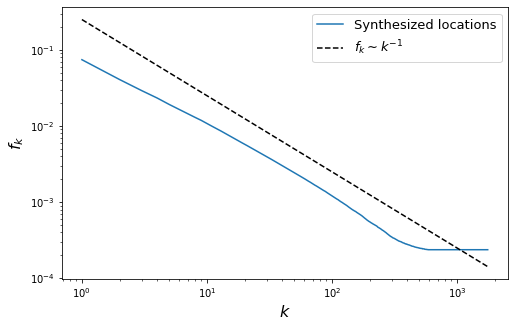

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))


n = np.arange(len(loc_S)) + 1
plt.plot(n, loc_S, label='Synthesized locations')




plt.plot(n,np.power(n,-1.0)/4, '--', label="$f_k\sim k^{-1}$", color = 'k')

plt.ylabel("$f_k$",fontsize = 16)
plt.xlabel("$k$",fontsize = 16)
plt.yscale('log')
plt.xscale('log')

plt.legend(prop={'size': 13})


# plt.savefig("data/out/fk_locs.png", dpi=600, bbox_inches='tight')

plt.show()

### Jump length

In [19]:
from trackintel.geogr.point_distances import  haversine_dist

def get_jump_length(gdf):
    geom_arr = gdf.geometry.values
    
    res_ls = []
    for i in range(1, len(geom_arr)):
        res_ls.append(haversine_dist(geom_arr[i-1].x, geom_arr[i-1].y, geom_arr[i].x, geom_arr[i].y)[0])
    return res_ls

jump_length = all_gdf.groupby("user_id").apply(get_jump_length)
flat_jump_length = [item for sublist in jump_length.to_list() for item in sublist]

In [20]:
print(np.max(flat_jump_length), np.min(flat_jump_length))

import powerlaw

jump_length_m = np.array(flat_jump_length)

# R, p = results.distribution_compare('power_law', 'lognormal')
# only select jump length longer than 5 meter
jump_length_m = jump_length_m[jump_length_m>5]

343521.8788981701 0.0


In [21]:
def getAIC(fit, empr):
    aics = []

    aics.append(-2*np.sum(fit.truncated_power_law.loglikelihoods(empr))+4)
    aics.append(-2*np.sum(fit.power_law.loglikelihoods(empr))+2)
    aics.append(-2*np.sum(fit.lognormal.loglikelihoods(empr))+4)
    
    aics = aics-np.min(aics)
    
    down = np.sum([np.exp(-aic/2) for aic in aics])    
        
    res = {}
    res['truncated_power_law'] = np.exp(-aics[0]/2)/down
    res['power_law'] = np.exp(-aics[1]/2)/down
    res['lognormal'] = np.exp(-aics[2]/2)/down

    return res

fit = powerlaw.Fit(jump_length_m, xmin=jump_length_m.min(), xmin_distribution='lognormal')
print(getAIC(fit, jump_length_m))

print(fit.xmin, fit.xmax)
print(fit.lognormal.parameter1, fit.lognormal.parameter2)

c:\ProgramData\Anaconda3\envs\hai\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


{'truncated_power_law': 0.0, 'power_law': 0.0, 'lognormal': 1.0}
16.93311493458873 None
9.515803066546798 2.2033698066627987


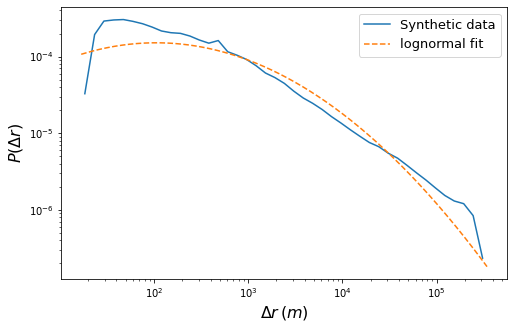

In [22]:
plt.figure(figsize=(8,5))

powerlaw.plot_pdf(jump_length_m, label='Synthetic data')

# fit.power_law.plot_pdf(linestyle = '--', label='powerlaw fit')
# fit.truncated_power_law.plot_pdf(linestyle = '--', label='truncated power law')
fit.lognormal.plot_pdf(linestyle = '--', label='lognormal fit')

plt.legend(prop={'size': 13})

plt.xlabel('$\Delta r\,(m)$', fontsize = 16)
plt.ylabel('$P(\Delta r)$', fontsize = 16)

plt.savefig("data/out/jump.png", dpi=600, bbox_inches='tight')

plt.show()

### Wait time

In [23]:

duration_hour = all_gdf["duration"].values
duration_hour = duration_hour[duration_hour>0.5]

In [24]:
print(np.max(duration_hour), np.min(duration_hour))

222.6408030372782 1.0000009354379096


In [25]:
fit = powerlaw.Fit(duration_hour, xmin=duration_hour.min(), xmin_distribution='lognormal')
print(getAIC(fit, duration_hour))

print(fit.xmin, fit.xmax)
print(fit.lognormal.parameter1, fit.lognormal.parameter2)
print(fit.truncated_power_law.parameter1, fit.truncated_power_law.parameter2)

c:\ProgramData\Anaconda3\envs\hai\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


{'truncated_power_law': 1.0, 'power_law': 0.0, 'lognormal': 0.0}
1.0000009354379096 None
0.8950711340314201 1.3465611942049298
1.0007353811759991 0.053146563762164784


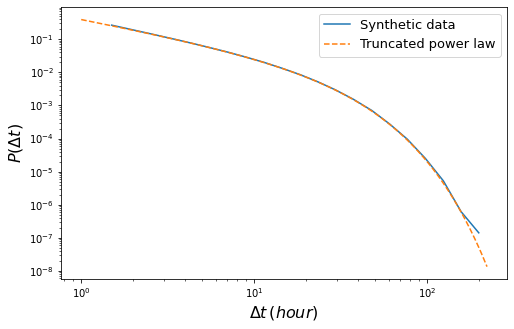

: 

In [26]:
plt.figure(figsize=(8,5))

powerlaw.plot_pdf(duration_hour, label='Synthetic data')

# fit.power_law.plot_pdf(linestyle = '--', label='powerlaw fit')
fit.truncated_power_law.plot_pdf(linestyle = '--', label='Truncated power law')
# fit.lognormal.plot_pdf(linestyle = '--', label='lognormal fit')

plt.legend(prop={'size': 13})

plt.xlabel('$\Delta t\,(hour)$', fontsize = 16)
plt.ylabel('$P(\Delta t)$', fontsize = 16)

plt.savefig("data/out/wait.png", dpi=600, bbox_inches='tight')
plt.show()